In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')
shuvoalok_ck_dataset_path = kagglehub.dataset_download('shuvoalok/ck-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')
shuvoalok_ck_dataset_path = kagglehub.dataset_download('shuvoalok/ck-dataset')

print('Data source import complete.')


In [ ]:
!pip install -q tensorflow

# Import necessary libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os, shutil, random
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



In [ ]:
# Paths
fer_train = "/kaggle/input/fer2013/train"
fer_test = "/kaggle/input/fer2013/test"
ck_data = "/kaggle/input/ck-dataset"
final_train = "final_data/train"
final_test = "final_data/test"

In [ ]:
# Emotion folder name mapping (CK+ → FER2013)
rename_map = {
    "Anger": "angry",
    "Disgust": "disgust",
    "Fear": "fear",
    "Happy": "happy",
    "Sadness": "sad",
    "Surprise": "surprise"
    # No 'Neutral' or 'Contempt'
}

In [ ]:
# 1. Copy FER data to final_data
def copy_folder(src, dst):
    for emotion in os.listdir(src):
        src_path = os.path.join(src, emotion)
        dst_path = os.path.join(dst, emotion)
        os.makedirs(dst_path, exist_ok=True)
        for file in os.listdir(src_path):
            shutil.copy(os.path.join(src_path, file), dst_path)

copy_folder(fer_train, final_train)
copy_folder(fer_test, final_test)

# 2. Split CK+ into train/test and add to final_data
split_ratio = 0.8

for folder in os.listdir(ck_data):
    emotion_path = os.path.join(ck_data, folder)
     # Skip non-directories
    if not os.path.isdir(emotion_path):
        continue

    # Skip unwanted classes
    if folder == "Contempt":
        print(f"Skipping folder: {folder}")
        continue

    # Rename to FER2013 style
    if folder not in rename_map:
        print(f"Unmapped folder: {folder}")
        continue

    new_emotion = rename_map[folder]
    files = os.listdir(folder_path)
    random.shuffle(files)
    files = os.listdir(emotion_path)
    random.shuffle(files)

    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    test_files = files[split_point:]

    for file in train_files:
        src = os.path.join(folder_path, file)
        dst = os.path.join(final_train, emotion)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(folder_path, file)
        dst = os.path.join(final_test, emotion)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(src, dst)



Unmapped folder: surprise
Unmapped folder: fear
Unmapped folder: sadness
Unmapped folder: disgust
Unmapped folder: contempt
Unmapped folder: happy
Unmapped folder: anger


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Define the path for the disgust class in the final_data directory
disgust_dir = os.path.join(final_train, "disgust")
os.makedirs(disgust_dir, exist_ok=True)
print("Augmenting images in:", disgust_dir)

# Directory to temporarily store augmented images (they will be saved into disgust_dir)
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# List all grayscale images in the 'disgust' folder
disgust_images = [img for img in os.listdir(disgust_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Number of augmentations per original image
augmentations_per_image = 20

print(f"Found {len(disgust_images)} original disgust images. Generating {augmentations_per_image}x per image...")

for img_name in tqdm(disgust_images):
    img_path = os.path.join(disgust_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue  # Skip unreadable images

    img = cv2.resize(img, (48, 48))
    img = np.expand_dims(img, axis=(0, -1))  # Shape: (1, 48, 48, 1)

    # Generate and save augmented images
    aug_iter = augmenter.flow(
        img,
        batch_size=1,
        save_to_dir=disgust_dir,
        save_prefix="aug_disgust",
        save_format="png"
    )

    for i in range(augmentations_per_image):
        next(aug_iter)

print(" Disgust augmentation complete.")




Augmenting images in: final_data/train/disgust
Found 436 original disgust images. Generating 20x per image...


100%|██████████| 436/436 [00:09<00:00, 43.91it/s]

 Disgust augmentation complete.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
train_generator = train_gen.flow_from_directory(
    final_train,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical"
)


Found 34534 images belonging to 7 classes.


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
    final_test,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False  # IMPORTANT: Don’t shuffle for evaluation
)

Found 7178 images belonging to 7 classes.


In [ ]:
class_indices = train_generator.class_indices
# Compute class weights to handle imbalanced dataset
train_classes = np.array(train_generator.classes)
class_labels = np.unique(train_classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_classes)
class_weights_dict = dict(enumerate(class_weights))
disgust_class_index=class_indices['disgust']
class_weights_dict[disgust_class_index] = max(class_weights_dict[disgust_class_index], 1.5)

print("Final class weights:", class_weights_dict)

Final class weights: {0: np.float64(1.2349007688181655), 1: 1.5, 2: np.float64(1.2041563513372153), 3: np.float64(0.6837738837738838), 4: np.float64(0.9936412027046468), 5: np.float64(1.021413782904466), 6: np.float64(1.5557958282650808)}


In [ ]:
from tensorflow.keras.regularizers import l2

# Define an improved CNN architecture
model = Sequential([
    Input(shape=(48,48,1)),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 Emotion Classes
])

In [ ]:
# Define optimizer with weight decay
optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)

# Compile model with label smoothing
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizer,
    metrics=["accuracy"]
)
# Show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,931,719 (22.63 MB)

 Trainable params: 5,930,823 (22.62 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=90,
    class_weight=class_weights_dict,
    callbacks=[early_stopping,lr_scheduler]
)

Epoch 1/90


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


540/540 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.1977 - loss: 2.5192 - val_accuracy: 0.1151 - val_loss: 2.1204 - learning_rate: 3.0000e-04
Epoch 2/90
540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.2373 - loss: 2.1731 - val_accuracy: 0.1158 - val_loss: 2.0889 - learning_rate: 3.0000e-04
Epoch 3/90
540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.2661 - loss: 2.0891 - val_accuracy: 0.1154 - val_loss: 2.0552 - learning_rate: 3.0000e-04
Epoch 4/90
540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.2796 - loss: 2.0249 - val_accuracy: 0.1718 - val_loss: 2.0183 - learning_rate: 3.0000e-04
Epoch 5/90
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.2935 - loss: 1.9771 - val_accuracy: 0.1716 - val_loss: 1.9932 - learning_rate: 3.0000e-04
Epoch 6/90
540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.2908 - loss: 1.9475 - val_accuracy: 0.1722 - val_loss: 1.9709 - learning_rate: 3.0000e-04
Epoch 7/90
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accurac

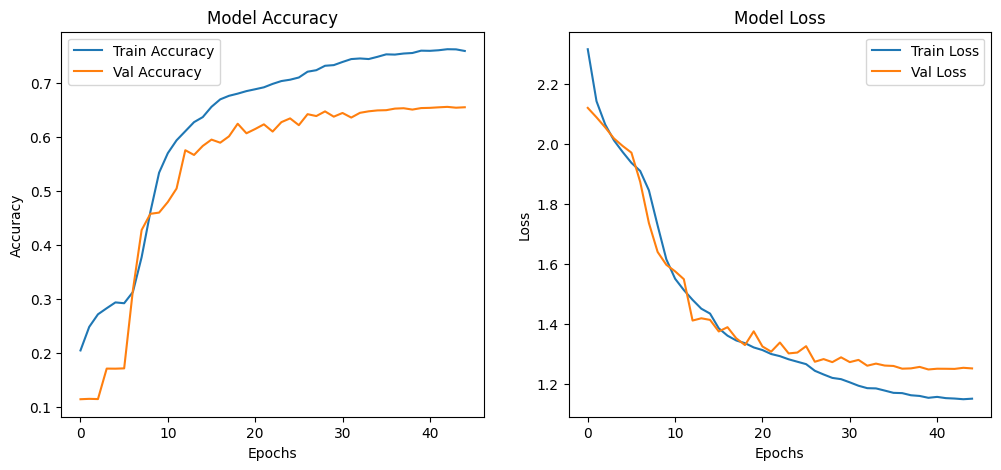

In [ ]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

plot_metrics(history)

In [ ]:
# Model saving in .h5, also specify the path
model.save("model.keras")

In [ ]:
# Evaluate the model on the FER-2013 test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6084 - loss: 1.3213
Test Accuracy: 65.41%
Test Loss: 1.2477


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


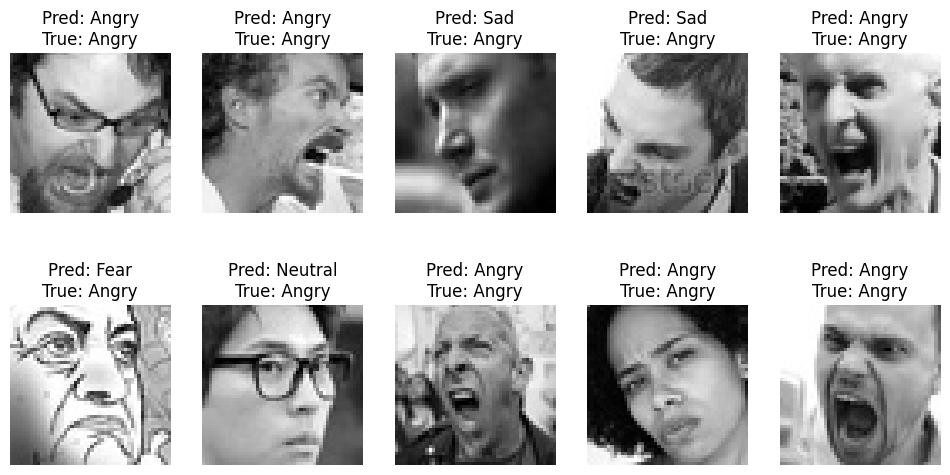

In [ ]:
import numpy as np

# Get a batch of test images and labels
images, labels = next(iter(test_generator))

# Predict on the batch
predictions = model.predict(images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Class labels for FER-2013
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Plot sample images with predicted labels
plt.figure(figsize=(12,6))
for i in range(10):  # Show first 10 images
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"Pred: {emotion_labels[predicted_classes[i]]}\nTrue: {emotion_labels[true_classes[i]]}")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


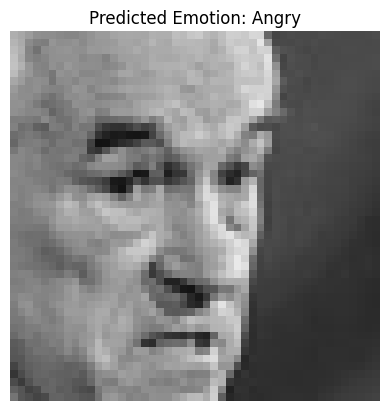

In [ ]:
import random

# Pick a random test image
random_index = random.randint(0, len(test_generator.filenames)-1)
img_path = os.path.join(final_test, test_generator.filenames[random_index])

# Load and preprocess the image
def predict_emotion(img_path, model):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48,48))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)

    prediction = model.predict(img)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    predicted_emotion = emotion_labels[np.argmax(prediction)]

    plt.imshow(cv2.imread(img_path))
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis("off")
    plt.show()

predict_emotion(img_path, model)

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


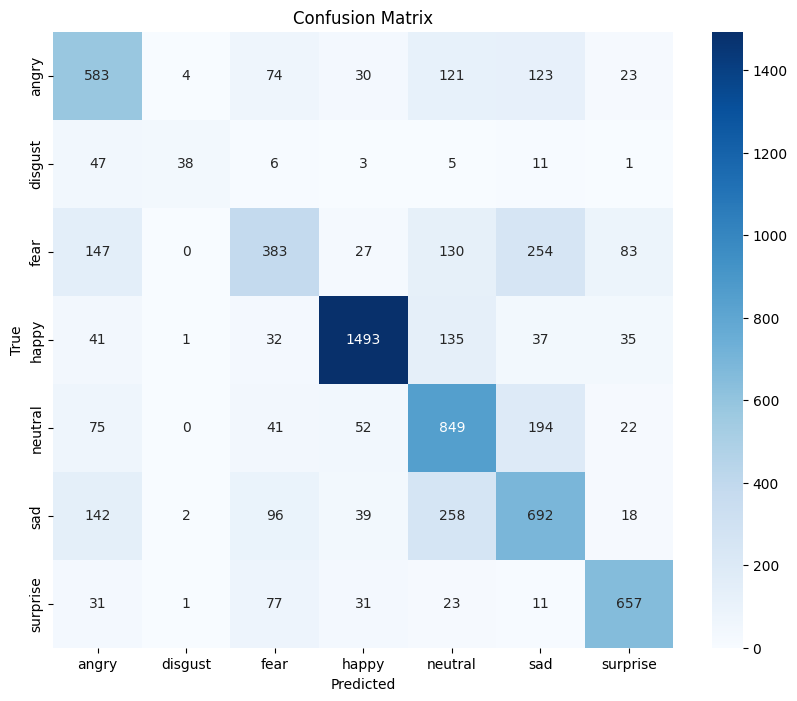

Classification Report:

              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       958
     disgust       0.83      0.34      0.48       111
        fear       0.54      0.37      0.44      1024
       happy       0.89      0.84      0.87      1774
     neutral       0.56      0.69      0.62      1233
         sad       0.52      0.55      0.54      1247
    surprise       0.78      0.79      0.79       831

    accuracy                           0.65      7178
   macro avg       0.67      0.60      0.62      7178
weighted avg       0.66      0.65      0.65      7178



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Predict class probabilities
predictions = model.predict(test_generator)

# Get predicted class indices
y_pred = np.argmax(predictions, axis=1)

# Get true class indices
y_true = test_generator.classes

# Class labels (based on folder order)
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
import os

# Path to the 'disgust' folder in training data
disgust_path = os.path.join(final_train, "disgust")

# Count all image files (commonly used formats)
disgust_images = [f for f in os.listdir(disgust_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Number of 'disgust' images in training data: {len(disgust_images)}")

Number of 'disgust' images in training data: 6261


In [ ]:
print("Disgust confusion row:", cm[1])